In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader

from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import matplotlib.pyplot as plt

In [51]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
CLASSES = ['normal', 'pneumonia', 'tuberculosis']
NUM_CLASSES = len(CLASSES)
EPOCHS = 2

In [5]:
preprocess_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
data_augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
])

In [9]:
# Load dataset
train_dataset = datasets.ImageFolder(root='D:/Jupyter/chexscan-folder/chexscan-experiment/data/train_data', transform=preprocess_transform)
valid_dataset = datasets.ImageFolder(root='D:/Jupyter/chexscan-folder/chexscan-experiment/data/test_data', transform=preprocess_transform)

In [52]:
# Define training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = EPOCHS
learning_rate = 0.001

In [14]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Functions

In [42]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
        
        # Compute training accuracy and loss
        train_accuracy = correct / total
        train_loss = running_loss / len(train_loader)
        history['accuracy'].append(train_accuracy)
        history['loss'].append(train_loss)
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        val_running_loss = 0.0
        
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_running_loss += loss.item()
        
        # Compute validation accuracy and loss
        val_accuracy = correct / total
        val_loss = val_running_loss / len(valid_loader)
        history['val_accuracy'].append(val_accuracy)
        history['val_loss'].append(val_loss)
        
        # Print training progress
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy*100:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy*100:.2f}%")
    
    return history

In [43]:
def evaluate_model(model, valid_loader, device='cpu'):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_predictions

In [44]:
def plot_history_metrics(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.plot(history['loss'], label='Training Loss', color='green')
    plt.plot(history['val_loss'], label='Validation Loss', color='red')
    plt.title('Training and Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.ylim(0, 1)  # Set y-axis limits to ensure range is from 0 to 1
    plt.legend()
    plt.grid(True)
    plt.show()

# ResNet-18

In [45]:
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [46]:
# Create ResNet model instance
resnet_model = ResNet(NUM_CLASSES).to(device)

D:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [53]:
history = train_model(resnet_model, train_loader, valid_loader, criterion, optimizer, num_epochs=EPOCHS, device=device)

Epoch [1/2], Loss: 1.4018, Accuracy: 27.59%, Val Loss: 1.3326, Val Accuracy: 30.00%
Epoch [2/2], Loss: 1.4086, Accuracy: 28.15%, Val Loss: 1.3378, Val Accuracy: 30.00%


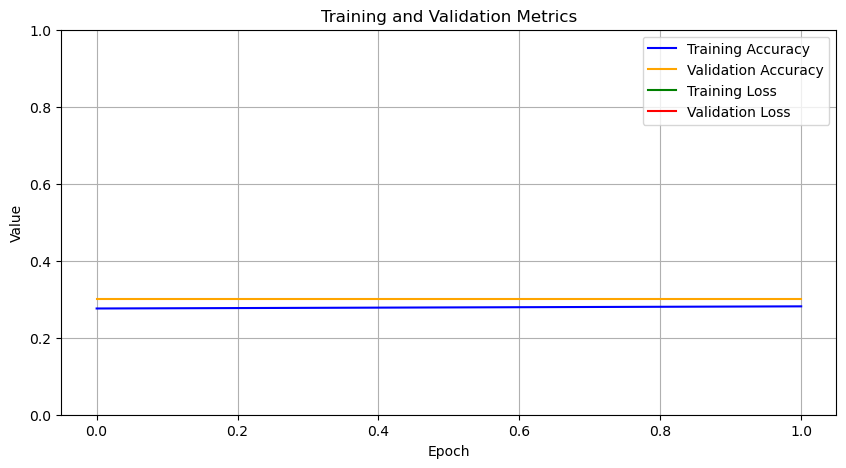

In [54]:
plot_history_metrics(history)

In [55]:
true_labels, predictions = evaluate_model(resnet_model, valid_loader, device=device)
print(classification_report(true_labels, predictions, target_names=class_names))

              precision    recall  f1-score   support

      normal       0.32      0.75      0.45        20
   pneumonia       0.00      0.00      0.00        20
tuberculosis       0.23      0.15      0.18        20

    accuracy                           0.30        60
   macro avg       0.18      0.30      0.21        60
weighted avg       0.18      0.30      0.21        60



D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


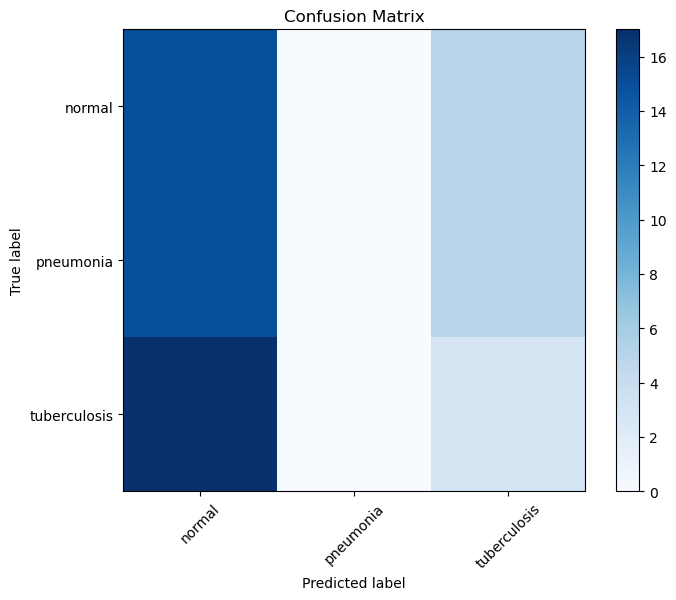

In [56]:
conf_mat = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

In [20]:
# Training loop
for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Print statistics
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {(correct / total) * 100:.2f}%")

Epoch [1/3], Loss: 1.4122, Accuracy: 32.78%
Epoch [2/3], Loss: 1.4139, Accuracy: 32.78%
Epoch [3/3], Loss: 1.4079, Accuracy: 32.78%


In [28]:
resnet_model.eval()
correct = 0
total = 0
all_predictions = []
all_labels = []
with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
print(f"Accuracy on validation set: {(correct / total) * 100:.2f}%")

Accuracy on validation set: 33.33%


In [29]:
# Compute classification report and confusion matrix
class_names = ['normal', 'pneumonia', 'tuberculosis']
print(classification_report(all_labels, all_predictions, target_names=class_names))
conf_mat = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00        20
   pneumonia       0.00      0.00      0.00        20
tuberculosis       0.34      1.00      0.51        20

    accuracy                           0.33        60
   macro avg       0.11      0.33      0.17        60
weighted avg       0.11      0.33      0.17        60



D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NameError: name 'plt' is not defined